# Group 4 Data Story

Our group was interested in exploring DESCRIBE SUMMARY OF OUR PROJECT

This notebook contains the following sections:
- UPDATE THIS WITH THE CONTENTS OF OUR NOTEBOOK!

In [2]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
#import lib.func_file as ff
#from lib.visual_figure4 import performance_sigma_point
#from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan


In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

# Part 1: Interpretability & Input Features

[PB] work on sorting by latitude

## Mixed Layer Depth

Sane et al. (2023) found that the bias between the mixed layer depths from their neural network parametrization and the physics-based parametrization was higher in winter than spring, which corresponds to deeper mixed layers. This finding, that bias is higher with deep mixed layers, indicates there are more complicated processes at work during winter when convection can occur due to weaker stratification.

Below we calculate the correlation between our input variables (Coriolis parameter, surface bouyancy flux, surface friction velocity, and boundary layer depth) and the diffusivity shape function they correspond to based on different boundary layer depths.

In [5]:
#this function takes an upper and lower depth boundary and filters the data to only those depths
#then it computes the correlation matrix between the 4 input variables (lat, bouyancy, velocity, and depth) and each point of the shape function
def correlation_by_depth(depth_min, depth_max):
    d_depth = d.where((d.h.compute() < depth_max) & (d.h.compute() > depth_min), drop=True)
    l0_depth    =corio(d_depth['l'][:])
    b00_depth   =d_depth['b0'][:]
    ustar0_depth=d_depth['ustar'][:]
    h0_depth    =d_depth['h'][:]
    lat0_depth  =d_depth['lat'][:]
    heat0_depth =d_depth['heat'][:]
    tx0_depth   =d_depth['tx'][:] 
    tx0_depth   =np.round(tx0_depth,2)
    SF0_depth   =d_depth['SF'][:] 
    
    data_depth = {
        "l0": l0_depth.values.flatten(),
        "b00": b00_depth.values.flatten(),
        "ustar0": ustar0_depth.values.flatten(),
        "h0": h0_depth.values.flatten(),
    }
    
    for i in range(16):
        data_depth[f"SF0_{i+1}"] = SF0_depth[:, 16-i-1].values.flatten()
    
    df_depth = pd.DataFrame(data_depth)
    correlation_matrix_depth = df_depth.corr()
    sf0_correlation_depth = correlation_matrix_depth.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

    return sf0_correlation_depth

In [6]:
#select depth ranges)
bins = [0,25,50,700]

In [7]:
#compute correlation matrix for a certain depth range
correlation_0_25 = correlation_by_depth(bins[0],bins[1])
correlation_0_50 = correlation_by_depth(bins[0],bins[2])
correlation_50_700 = correlation_by_depth(bins[2],bins[3])
correlation_0_700 = correlation_by_depth(bins[0],bins[3])

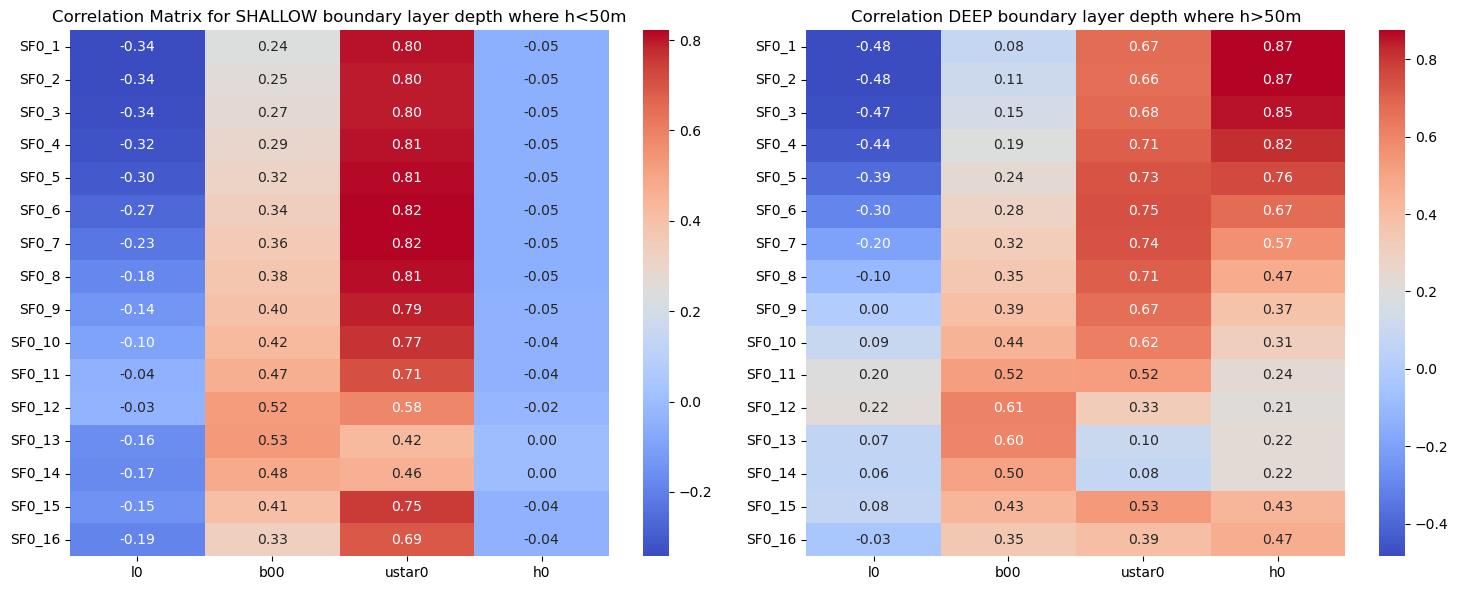

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(correlation_0_50, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[0])
axs[0].set_title("Correlation Matrix for SHALLOW boundary layer depth where h<{}m".format(bins[2]))

sns.heatmap(correlation_50_700, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation DEEP boundary layer depth where h>{}m".format(bins[2]))

plt.tight_layout()
plt.show()

The plots above show the correlation matrices for the dataset filtered in 2 ways: only the data with boundary layers less than 50m and only the data with boundary layers greater than 50m. Some of the correlations look fairly similar between the two. Bouyancy flux for example has visually very similar correlations. For shallow boundary layers, the boundary layer input has little correlation which makes sense (because we've chosen similar regimes), however for deep boundary layers there is higher correlation, likely because there is a larger range of h values. Latitude and velocity both have similar patterns in correlation, just shifted slightly (shallow boundary layers have higher correlation for velocity and lower for latitude).

These plots can be complicated to interpret because there are many values to look at. In order to simplify, we added the (absolute value of) correlation for each depth point across all four inputs to compare the overall strength of correlation for each point across different boundary layer depth regimes.

In [9]:
correlation_0_25_sum = correlation_0_25.abs().sum(axis=1)
correlation_0_50_sum = correlation_0_50.abs().sum(axis=1)
correlation_50_700_sum = correlation_50_700.abs().sum(axis=1)
correlation_0_700_sum = correlation_0_700.abs().sum(axis=1)
y = np.arange(1,17)

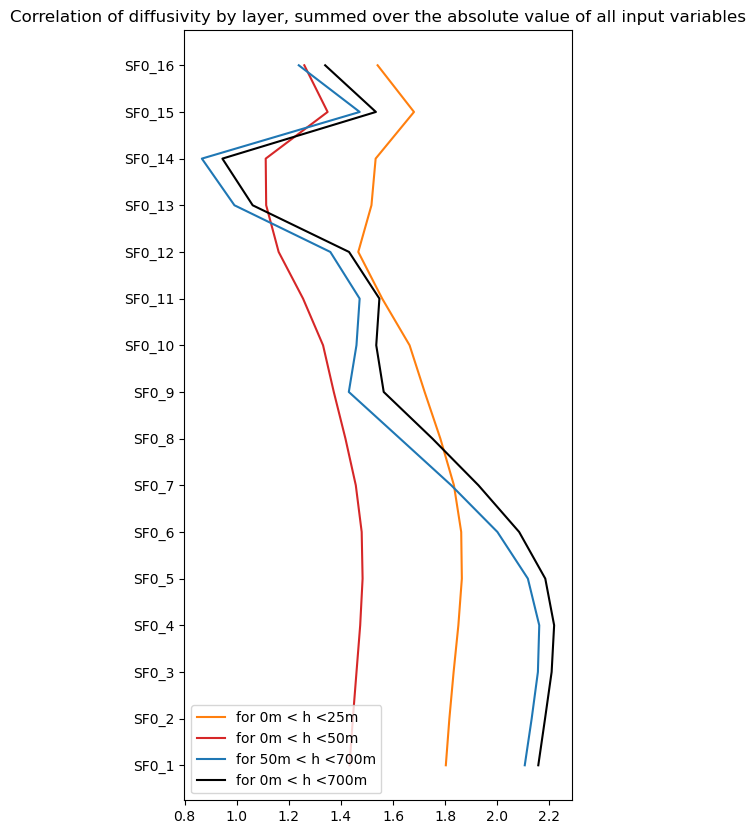

In [11]:
plt.figure(figsize=(5,10))
plt.plot(correlation_0_25_sum, y, label=f"for {bins[0]}m < h <{bins[1]}m", color='tab:orange')
plt.plot(correlation_0_50_sum, y, label=f"for {bins[0]}m < h <{bins[2]}m", color='tab:red')
plt.plot(correlation_50_700_sum, y, label=f"for {bins[2]}m < h <{bins[3]}m", color='tab:blue')
plt.plot(correlation_0_700_sum, y, label=f"for {bins[0]}m < h <{bins[3]}m", color='k')
#plt.gca().invert_yaxis()
plt.legend()
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables');

This plot shows the absolute value of correlation summed across all 4 inputs for each point of the shape function for four different boundary layer depth regimes:
- 0 < h < 25: very shallow boundary layers (this would indicate high stratification, likely in summer)
- 0 < h < 50: shallow boundary layers
- 50 < h < 700: deep boundary layers (this would indicate weak stratification, likely in winter)
- 0 < h < 700: entire dataset, no sorting by boundary layer depth

This plot indicates that the highest correlation at the surface (point 16) is for very shallow boundary layers, those less than 25m. This relates to the paper's finding that shallow boundary layers had lower bias. Interesting though, there is not a significant differnce between all shallow boundary layers (0<h<25) compared to deep boundary layers (50<h<700) in the upper points of the profile. This could suggest that high correlation is specific to a very small group of the shallowest mixed layers. Contrastingly, at the base of the profile (deeper in the ocean, at point 1) deep mixed layers have the highest correlation. 

# Part 2: Model Improvement

[CL] work on step-by-step model architecture

[BH] work on XGBoost model? (if it seems like it's training)